In [33]:
import requests
from datetime import datetime

headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36'}
now = datetime.now()
data_url = 'https://iboard-api.ssi.com.vn/statistics/company/ssmi/stock-info?symbol={}&page=1&pageSize=1000&fromDate=01/08/2021&toDate={}'
list_symbol_url = 'https://iboard-query.ssi.com.vn/stock/exchange/hose?boardId=MAIN'

In [ ]:
data = {}
def get_data(symbol):

    print(symbol)
    data[symbol] = {}
    data_res = requests.get(data_url.format(symbol, now.strftime('%d/%m/%Y')), headers=headers).json()
    
    for row in data_res['data']:
        date = row['tradingDate']
        data[symbol][date] = {}
        data[symbol][date]['ClosePrice'] = float(row['close'])
        data[symbol][date]['ClosePriceAdjusted'] = float(row['closePriceAdjusted'])

        if  row['foreignBuyVolTotal'] != None:
            data[symbol][date]['BuyVolume'] = float(row['foreignBuyVolTotal'])
        else:
            data[symbol][date]['BuyVolume'] = 0

        if row['foreignSellVolTotal'] != None:
            data[symbol][date]['SellVolume'] = float(row['foreignSellVolTotal'])
        else:
            data[symbol][date]['SellVolume'] = 0
        if row['foreignBuyValTotal'] != None:
            data[symbol][date]['BuyValue'] = float(row['foreignBuyValTotal'])
        else:
            data[symbol][date]['BuyValue'] = 0
        if row['foreignSellValTotal'] != None:
            data[symbol][date]['SellValue'] = float(row['foreignSellValTotal'])
        else:
            data[symbol][date]['SellValue'] = 0

list_symbol_res = requests.get(list_symbol_url, headers=headers).json()['data']
list_symbol = [r['stockSymbol'] for r in list_symbol_res]
for symbol in list_symbol:
    get_data(symbol)

In [42]:
def compute_profit(symbol):
    
    list_date = [k for k in data[symbol]]
    list_date.reverse()
    
    mdata = data[symbol]
    
    total_buy_volume = 0; total_buy_value = 0
    total_sell_volume = 0; total_sell_value = 0
    
    all_profit = []
    
    for date in list_date:
        
        rate = mdata[date]['ClosePriceAdjusted'] / mdata[date]['ClosePrice']
    
        if 'BuyVolume' in mdata[date]:
            buy_volume_adjusted = mdata[date]['BuyVolume'] / rate
        else:
            buy_volume_adjusted = 0
        if 'SellVolume' in mdata[date]:
            sell_volume_adjusted = mdata[date]['SellVolume'] / rate
        else:
            sell_volume_adjusted = 0
    
        total_buy_volume += buy_volume_adjusted
        total_sell_volume += sell_volume_adjusted
    
        if 'BuyValue' in mdata[date]:
            total_buy_value += mdata[date]['BuyValue']
        if 'SellValue' in mdata[date]:
            total_sell_value += mdata[date]['SellValue']
    
        profit = (float(mdata[date]['ClosePriceAdjusted']) * total_buy_volume - total_buy_value) + (total_sell_value - float(mdata[date]['ClosePriceAdjusted']) * total_sell_volume)
        all_profit.append(profit / 1e9)
        
    return list_date, all_profit

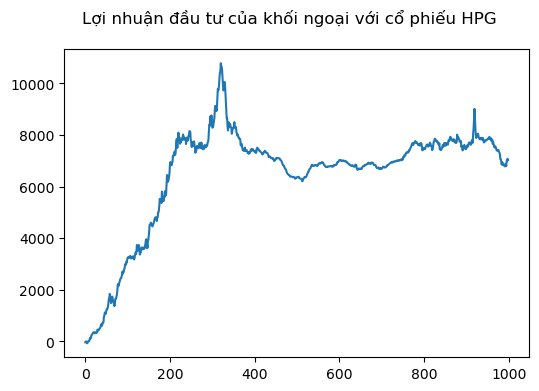

In [70]:
import matplotlib.pyplot as plt
symbol = 'HPG'
list_date, all_profit = compute_profit(symbol)
plt.figure(figsize=(6, 4))
plt.suptitle('Lợi nhuận đầu tư của khối ngoại với cổ phiếu ' + symbol)
plt.plot(all_profit)
# plt.savefig('img/khoingoai_{}.png'.format(symbol))
plt.show()

In [52]:
profit_lastday = {}
for symbol in list_symbol:
    _, all_profit = compute_profit(symbol)
    profit_lastday[symbol] = all_profit[-1]
sum([profit_lastday[k] for k in profit_lastday])

-13214.185128349873

In [ ]:
{k: v for k, v in sorted(profit_lastday.items(), key=lambda item: item[1], reverse=True)}

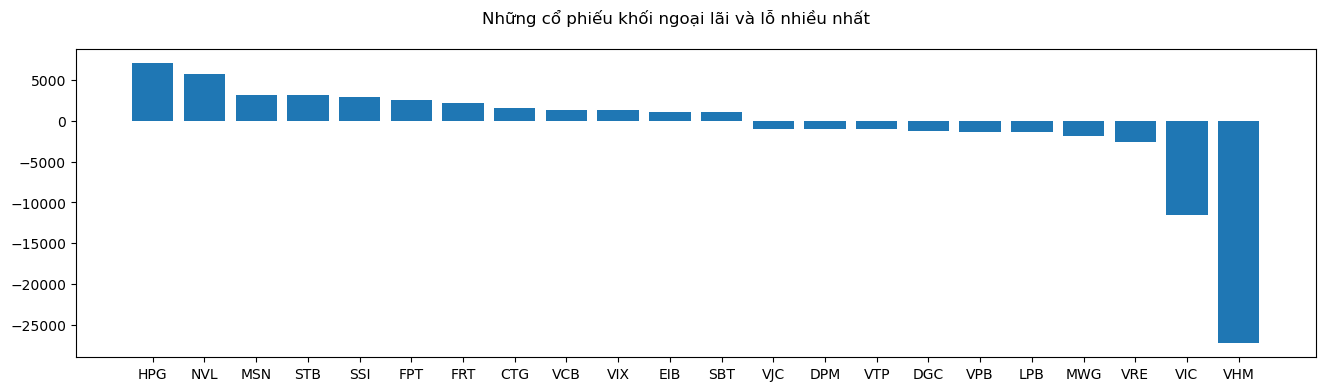

In [71]:
profit_lastday_ = {k: v for k, v in sorted(profit_lastday.items(), key=lambda item: item[1], reverse=True) if v > 1000 or v < -1000}

symbols = [k for k in profit_lastday_]
values = [profit_lastday_[k] for k in profit_lastday_]

plt.figure(figsize=(16, 4))
plt.bar(symbols, values)
plt.suptitle('Những cổ phiếu khối ngoại lãi và lỗ nhiều nhất')
plt.savefig('img/top_khoingoai_.png')
plt.show()